# **1. Xử lý dữ liệu Technical Drawing**

In [2]:
import os
import json
import random
from PIL import Image, ImageEnhance
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# Đường dẫn tới thư mục chứa ảnh và file labels.json
image_folder = '/kaggle/input/technicaldrawing/images'
label_file_path = '/kaggle/input/technicaldrawing/labels.json'
output_folder = '/kaggle/working/normalized_images'  # Đường dẫn đến thư mục lưu ảnh đã chuẩn hóa
augmented_folder = '/kaggle/working/augmented_images'  # Đường dẫn đến thư mục lưu ảnh augmented
updated_label_file_path = '/kaggle/working/updated_labels.json'  # Đường dẫn lưu file labels đã cập nhật

# Tạo thư mục output và augmented nếu chưa tồn tại
os.makedirs(output_folder, exist_ok=True)
os.makedirs(augmented_folder, exist_ok=True)

# Đọc dữ liệu từ labels.json
with open(label_file_path, 'r') as f:
    labels_data = json.load(f)

In [4]:
# Hàm chuẩn hóa ảnh
def preprocess_image(image_path, output_path, size=(512, 512)):
    with Image.open(image_path) as img:
        img_resized = img.convert('RGB').resize(size)
        img_resized.save(output_path, format='JPEG')

# Hàm tạo và chuẩn hóa ảnh augmented
def augment_image(image_path, output_folder, augment_folder, augmentations=['flip_90', 'flip_180', 'flip_270', 'h_flip', 'v_flip', 'brightness', 'contrast', 'noise'], size=(512, 512)):
    with Image.open(image_path) as img:
        # Tạo một bản chuẩn hóa gốc
        base_img_path = os.path.join(output_folder, os.path.basename(image_path))
        preprocess_image(image_path, base_img_path, size=size)

        # Tạo ảnh augmented từ ảnh đã chuẩn hóa
        augmented_paths = []
        for i, aug_type in enumerate(augmentations):
            img_aug = img.convert('RGB')
            if aug_type == 'flip_90':
                img_aug = img_aug.transpose(Image.Transpose.ROTATE_90)
            elif aug_type == 'flip_180':
                img_aug = img_aug.transpose(Image.Transpose.ROTATE_180)
            elif aug_type == 'flip_270':
                img_aug = img_aug.transpose(Image.Transpose.ROTATE_270)
            elif aug_type == 'h_flip':
                img_aug = img_aug.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
            elif aug_type == 'v_flip':
                img_aug = img_aug.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
            elif aug_type == 'brightness':
                enhancer = ImageEnhance.Brightness(img_aug)
                img_aug = enhancer.enhance(random.uniform(0.7, 1.3))
            elif aug_type == 'contrast':
                enhancer = ImageEnhance.Contrast(img_aug)
                img_aug = enhancer.enhance(random.uniform(0.7, 1.3))
            elif aug_type == 'noise':
                img_aug = np.array(img_aug)
                noise = np.random.normal(0, 0.1, img_aug.shape)
                img_aug = np.clip(img_aug + noise * 255, 0, 255).astype(np.uint8)
                img_aug = Image.fromarray(img_aug)

            # Đảm bảo mỗi ảnh augmented có cùng kích thước chuẩn hóa
            img_aug = img_aug.resize(size)
            aug_img_name = f"{os.path.splitext(os.path.basename(image_path))[0]}_aug_{i+1}.jpg"
            aug_img_path = os.path.join(augment_folder, aug_img_name)
            img_aug.save(aug_img_path, format='JPEG')
            augmented_paths.append(aug_img_path)
        return base_img_path, augmented_paths

In [5]:
# Tạo danh sách lưu trữ
augmented_labels = []
augmentations=['flip_90', 'flip_180', 'flip_270', 'h_flip', 'v_flip', 'brightness', 'contrast', 'noise']

# Lặp qua từng ảnh trong labels_data
for entry in labels_data:
    image_path = os.path.join(image_folder, os.path.basename(entry["image_path"]))
    if os.path.exists(image_path):
        # Tạo ảnh chuẩn hóa và ảnh augmented
        base_img_path, aug_img_paths = augment_image(image_path, output_folder, augmented_folder)

        # Cập nhật entry gốc với đường dẫn ảnh chuẩn hóa
        entry["image_path"] = base_img_path
        entry["augmented_type"] = "original"

        # Thêm từng ảnh augmented vào labels
        # Use enumerate to get both the index (i) and the value (aug_path)
        for i, aug_path in enumerate(aug_img_paths):
            new_entry = entry.copy()
            new_entry["image_path"] = aug_path
            # Access augmentations using the index (i)
            new_entry["augmented_type"] = augmentations[i]
            augmented_labels.append(new_entry)

# Bổ sung augmented_labels vào labels_data và lưu lại
labels_data.extend(augmented_labels)

# Lưu file json đã cập nhật
with open(updated_label_file_path, 'w') as f:
    json.dump(labels_data, f, indent=4)

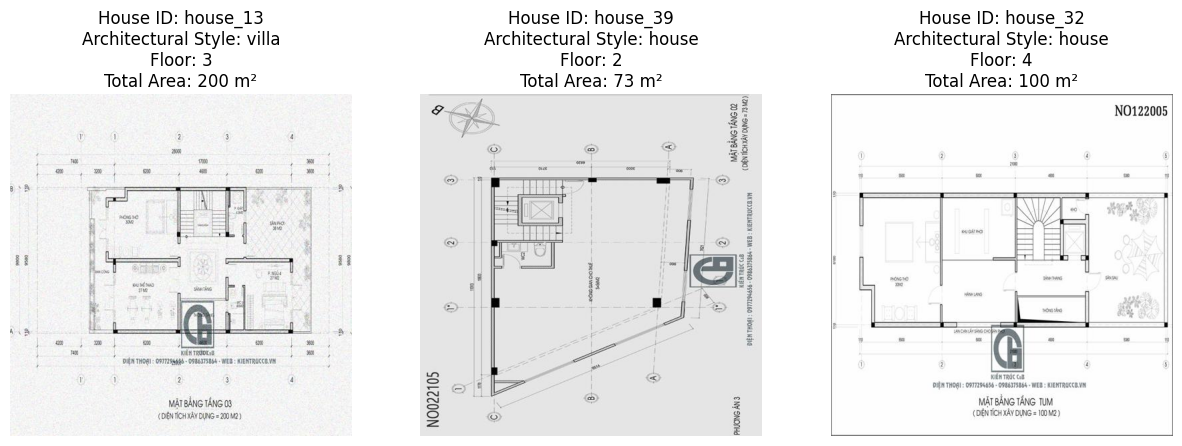

In [6]:
# Hiển thị một vài ảnh mẫu cùng thông tin chi tiết
num_samples = 3
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
# Chọn ngẫu nhiên 3 chỉ mục từ labels_data
sample_indices = random.sample(range(len(labels_data)), num_samples)
for i, idx in enumerate(sample_indices):
    entry = labels_data[idx]
    img_path = entry["image_path"]
    with Image.open(img_path) as img:
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        # Hiển thị thông tin chi tiết dưới ảnh
        info = f"House ID: {entry['house_id']}\nArchitectural Style: {entry['architectural_style']}\nFloor: {entry['floor']}\nTotal Area: {entry['total_area']} m²"
        axes[i].set_title(info)
plt.show()

In [7]:
# In ra kích thước của labels_data
print(f"Số lượng mẫu trong labels_data: {len(labels_data)}")

Số lượng mẫu trong labels_data: 1170


# **2. Visualize data**

In [7]:
import plotly.graph_objects as go
# from anytree import Node, RenderTree
import networkx as nx
import seaborn as sns

In [8]:
# Hàm để vẽ biểu đồ cột số ngôi nhà theo khoảng diện tích
def plot_house_count_by_area(file_path):
    # Đọc dữ liệu từ file JSON
    with open(file_path, 'r') as f:
        houses_data = json.load(f)
    # 1. Biểu đồ cột: Hiển thị số ngôi nhà trong các khoảng diện tích
    area_ranges = ['< 70', '70-100', '100-150', '150-200', '200-250', '250-300']
    house_counts = [0] * len(area_ranges)
    # Đếm số ngôi nhà trong từng khoảng diện tích
    for house in houses_data:
        total_area = house['total_area']
        if total_area < 70:
            house_counts[0] += 1
        elif total_area < 100:
            house_counts[1] += 1
        elif total_area < 150:
            house_counts[2] += 1
        elif total_area < 200:
            house_counts[3] += 1
        elif total_area < 250:
            house_counts[4] += 1
        elif total_area < 300:
            house_counts[5] += 1
    
    # Vẽ biểu đồ cột
    plt.figure(figsize=(10, 6))
    plt.bar(area_ranges, house_counts, color='skyblue')
    plt.xlabel('Khoảng diện tích (m²)')
    plt.ylabel('Số ngôi nhà')
    plt.title('Số ngôi nhà theo khoảng diện tích')
    plt.xticks(rotation=45)  # Xoay nhãn trục x nếu cần
    plt.tight_layout()  # Đảm bảo bố cục tốt hơn
    plt.show()

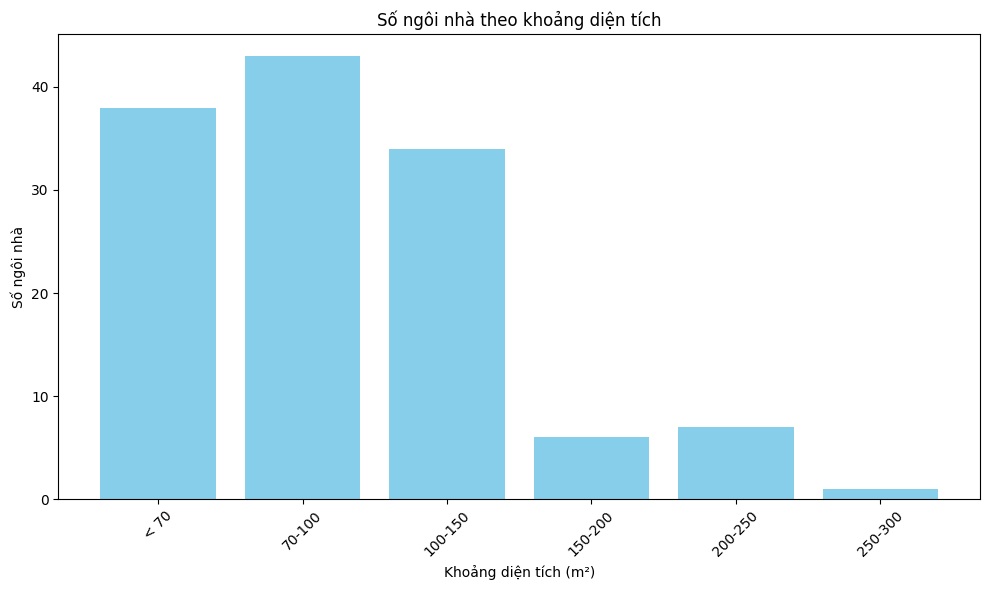

In [9]:
plot_house_count_by_area(label_file_path)

In [10]:
# Hàm chọn ngẫu nhiên một ngôi nhà và xây dựng cây
def display_random_house_structure(file_path):
    # Đọc dữ liệu từ file JSON
    with open(file_path, "r") as f:
        data = json.load(f)
    # Nhóm dữ liệu theo từng ngôi nhà bằng house_id
    houses = {}
    for entry in data:
        house_id = entry['house_id']
        if house_id not in houses:
            houses[house_id] = {
                "architectural_style": entry["architectural_style"],
                "floors": []
            }
        houses[house_id]["floors"].append(entry)
        
    # Chọn ngẫu nhiên một ngôi nhà
    random_house_id = random.choice(list(houses.keys()))
    random_house = houses[random_house_id]
    # Khởi tạo đồ thị
    G = nx.DiGraph()
    # Tạo node gốc cho ngôi nhà bao gồm cả architectural style
    house_node = f"House ID: {random_house_id}\nStyle: {random_house['architectural_style']}"
    G.add_node(house_node)
    # Thêm từng tầng và các phòng vào cây
    floor_nodes = []  # Danh sách để lưu trữ các node tầng
    for floor_data in random_house["floors"]:
        floor_node = f"Floor {floor_data['floor']} ({floor_data['total_area']} m²)"
        G.add_node(floor_node)
        G.add_edge(house_node, floor_node)
        floor_nodes.append(floor_node)  # Thêm node tầng vào danh sách
        # Thêm các phòng vào node tầng
        for room in floor_data["rooms"]:
            room_node = f"{room['type'].capitalize()}: {room['area']} m²"
            G.add_node(room_node)
            G.add_edge(floor_node, room_node)
        # Thêm các tính năng vào node tầng
        for feature in floor_data["feature"]:
            feature_node = f"Feature: {feature.capitalize()}"
            G.add_node(feature_node)
            G.add_edge(floor_node, feature_node)
    # Xác định vị trí cho các node theo cách thủ công
    pos = {house_node: (0, 1)}  # Node gốc ở trên cùng
    for i, floor_node in enumerate(floor_nodes):
        pos[floor_node] = (i * 2 - (len(floor_nodes) - 1), 0)  # Các tầng ở hàng dưới node gốc
        # Các phòng và tính năng sẽ được sắp xếp ở hàng tiếp theo
        room_y = -1
        feature_y = -1.5
        # Xác định vị trí cho các phòng
        for room in G.neighbors(floor_node):
            pos[room] = (pos[floor_node][0], room_y)  # Giữ cùng x nhưng giảm y
            room_y -= 0.5  # Giảm y để không chồng lên nhau
        # Xác định vị trí cho các tính năng
        for feature in G.neighbors(floor_node):
            pos[feature] = (pos[floor_node][0] + 0.5, feature_y)  # Bên cạnh phòng
            feature_y -= 0.5  # Giảm y để không chồng lên nhau
    # Vẽ đồ thị
    plt.figure(figsize=(24, 12))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
    plt.title(f"Structure of {random_house_id} - Style: {random_house['architectural_style']}")
    plt.show()

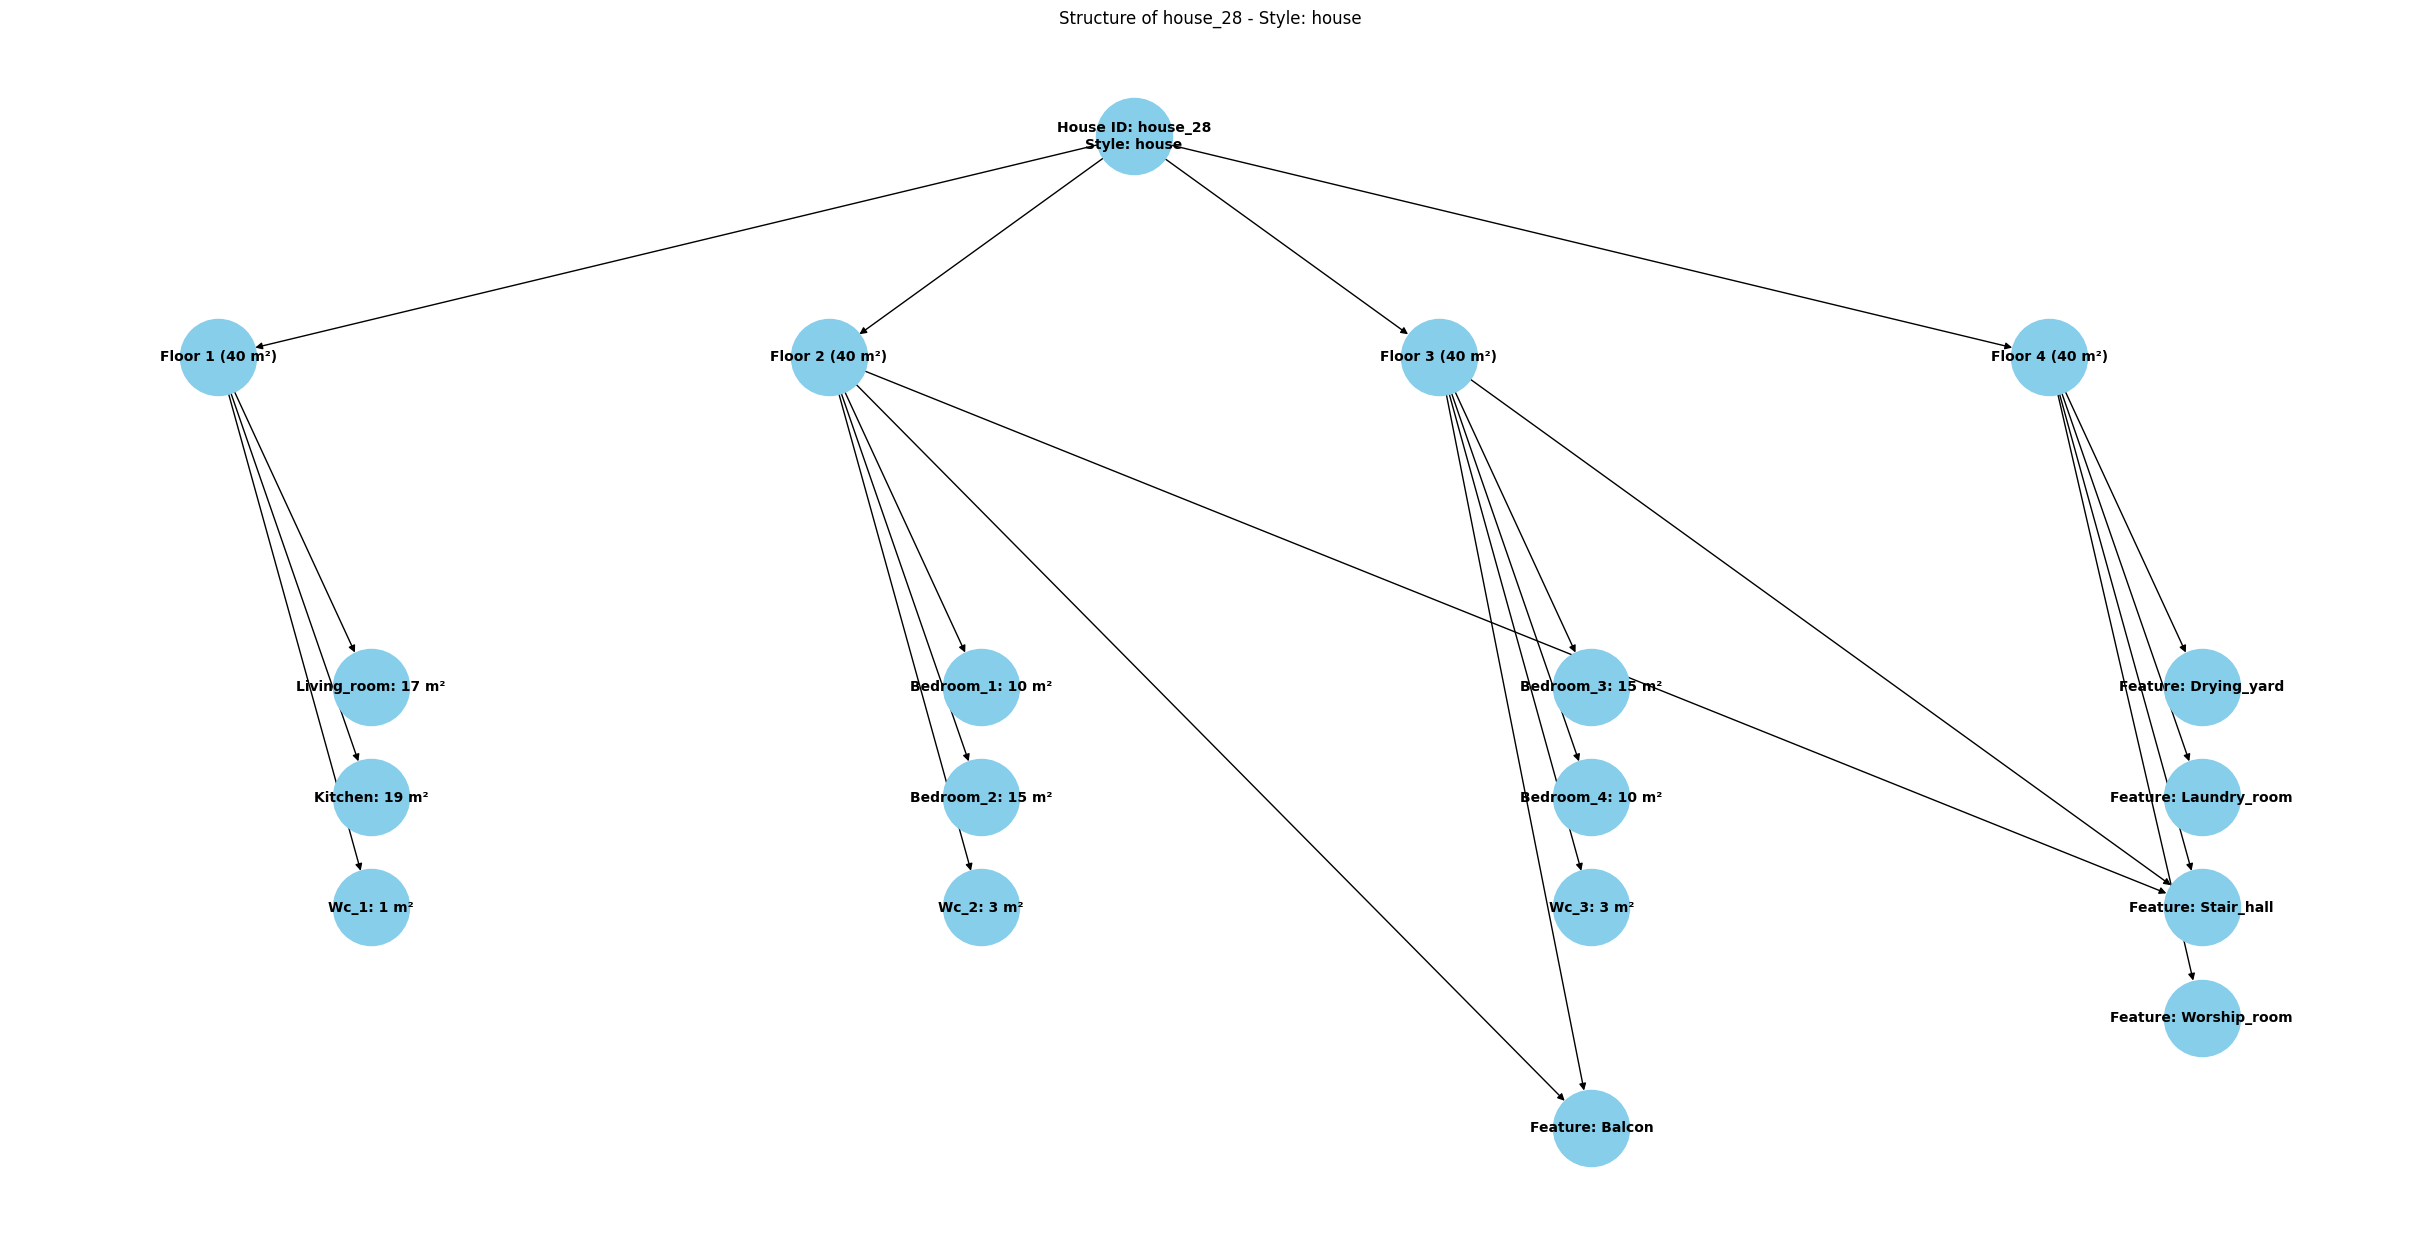

In [11]:
# Gọi hàm để hiển thị ngôi nhà ngẫu nhiên
display_random_house_structure(label_file_path)

In [12]:
# Hàm chọn ngẫu nhiên một ngôi nhà và vẽ biểu đồ tròn cho diện tích các phòng
def display_room_area_pie_chart(file_path):
    # Đọc dữ liệu từ file JSON
    with open(file_path, "r") as f:
        data = json.load(f)
    # Nhóm dữ liệu theo từng ngôi nhà bằng house_id
    houses = {}
    for entry in data:
        house_id = entry['house_id']
        if house_id not in houses:
            houses[house_id] = {
                "architectural_style": entry["architectural_style"],
                "floors": []
            }
        houses[house_id]["floors"].append(entry)
    # Chọn ngẫu nhiên một ngôi nhà
    random_house_id = random.choice(list(houses.keys()))
    random_house = houses[random_house_id]
    # Chuẩn bị dữ liệu cho biểu đồ tròn
    room_labels = []
    room_areas = []
    # Lấy diện tích của tất cả các phòng trong ngôi nhà ngẫu nhiên
    for floor_data in random_house["floors"]:
        for room in floor_data["rooms"]:
            room_labels.append(f"{room['type'].capitalize()} ({room['area']} m²)")
            room_areas.append(room['area'])
    # Vẽ biểu đồ tròn
    plt.figure(figsize=(10, 8))
    plt.pie(room_areas, labels=room_labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Đảm bảo biểu đồ tròn
    plt.title(f"Room Area Distribution in {random_house_id} - Style: {random_house['architectural_style']}")
    plt.show()

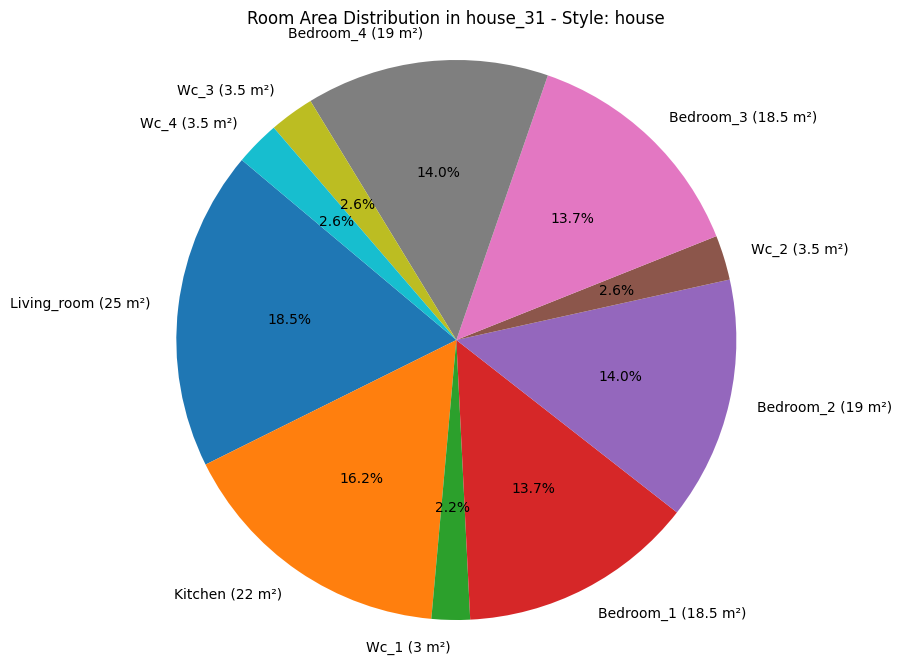

In [13]:
# Gọi hàm để hiển thị biểu đồ tròn cho diện tích các phòng
display_room_area_pie_chart(label_file_path)

In [14]:
# Hàm để vẽ biểu đồ hộp cho diện tích ngôi nhà theo architectural_style
def plot_area_distribution_by_style(file_path):
    # Đọc dữ liệu từ file JSON
    with open(file_path, 'r') as f:
        houses_data = json.load(f)
    # Tạo DataFrame để lưu trữ diện tích và kiểu kiến trúc
    data = []
    for house in houses_data:
        architectural_style = house['architectural_style']
        total_area = house['total_area']
        data.append({'Architectural Style': architectural_style, 'Total Area (m²)': total_area})
    df = pd.DataFrame(data)
    # Vẽ biểu đồ hộp
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Architectural Style', y='Total Area (m²)', data=df, palette='Set3')
    plt.title('Phân bố diện tích ngôi nhà theo kiểu kiến trúc')
    plt.xlabel('Kiểu kiến trúc')
    plt.ylabel('Diện tích (m²)')
    plt.xticks(rotation=45)  # Xoay nhãn trên trục x để dễ đọc hơn
    plt.grid(True)
    plt.show()

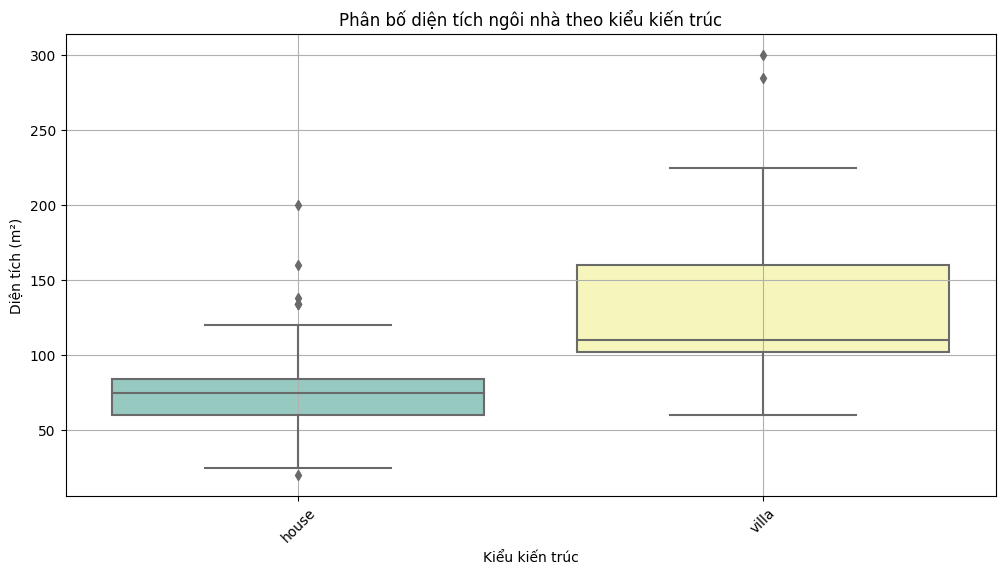

In [15]:
# Gọi hàm với đường dẫn đến file JSON của bạn
plot_area_distribution_by_style(label_file_path)

# **Tùy chỉnh lại data**

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
# from torchvision.models import resnet50, ResNet50_Weights
from sklearn.preprocessing import LabelEncoder

In [9]:
# Xác định danh sách các loại phòng và tính năng để tạo các vector có chiều cố định
room_types = ["living_room", "bedroom_1", "bedroom_2", "bedroom_3", "bedroom_4", "bedroom_5", "bedroom_6", "kitchen", "wc_1", "wc_2", "wc_3", "wc_4", "wc_5", "wc_6", "wc_7", "wc_8"]
features_list = ["yard", "main_hall", "side_hall", "laundry_area", "worship_room", "frontyard", "backyard",
                 "bar", "garage", "internal_corridor", "balcon", "lobby", "drying_yard", "library", "common_room",
                 "playground", "business_space", "hallway", "stair_hall", "side_hall", "warehouse", "technical_room",
                "miniatures", "dressing_room", "sports_area", "laundry_room", "relaxation_room", "parking_yard",
                 "skylight", "logia", "planting_yard", "yoga_room", "common_area", "sports_area", "karaoke_room",
                 "massage_room", "multi-purpose_room", "working_room", "sports_room", "rooftop"]

# Bộ mã hóa cho phong cách kiến trúc (nếu có danh sách cố định)
architectural_styles = ["house", "villa"]
architecture_encoder = LabelEncoder()
architecture_encoder.fit(architectural_styles)

# Bộ mã hóa cho các tính năng
feature_encoder = LabelEncoder()
feature_encoder.fit(features_list)

LabelEncoder()

In [10]:
def create_embedding(house_id, architectural_style, floor, total_area, room_areas, features, augmented_type="original"):
    # Mã hóa phong cách kiến trúc thành số
    arch_style_encoded = architecture_encoder.transform([architectural_style])[0]

    # Mã hóa ID ngôi nhà
    house_id_encoded = int(house_id.split('_')[1])

    # Vector diện tích các phòng
    numeric_embedding = [house_id_encoded, arch_style_encoded, floor, total_area] + [
            room_areas.get(room, 0) for room in room_types
        ]

    # Vector tính năng
    feature_embedding = [1 if feature in features else 0 for feature in features_list]

    # Mã hóa loại ảnh augmented (gán giá trị số)
    augment_type_encoded = hash(augmented_type) % 1000  # Lấy giá trị hash của loại augmented

    # Kết hợp tất cả các embedding lại thành một vector duy nhất
    embedding = np.concatenate([numeric_embedding, feature_embedding, [augment_type_encoded]])

    return embedding

In [11]:
# Dữ liệu cho house_id = "house_2" có hai tầng
house_data = [
    {
        "house_id": "house_2",
        "architectural_style": "house",
        "floor": 1,
        "image_path": "/content/drive/MyDrive/DeepLearning/TechinicalDrawing/images/house_2_floor_1.jpg",
        "total_area": 100,
        "rooms": [
            {"type": "living_room", "area": 20},
            {"type": "bedroom_1", "area": 13.7},
            {"type": "kitchen", "area": 27.5},
            {"type": "wc_1", "area": 3}
        ],
        "feature": ["backyard", "frontyard", "main_hall", "internal_corridor"]
    },
    {
        "house_id": "house_2",
        "architectural_style": "house",
        "floor": 1.5,
        "image_path": "/content/drive/MyDrive/DeepLearning/TechinicalDrawing/images/house_2_floor_1_5.jpg",
        "total_area": 100,
        "rooms": [
            {"type": "bedroom_1", "area": 11},
            {"type": "bedroom_2", "area": 11},
            {"type": "kitchen", "area": 25},
            {"type": "wc_1", "area": 5.4}
        ],
        "feature": ["balcon", "worship_room", "internal_corridor"]
    }
]

# Tạo danh sách lưu trữ
embeddings = []

# Lặp qua từng ngôi nhà trong labels_data
for house in house_data:
    house_id = house['house_id']
    architectural_style = house["architectural_style"]
    floor = house['floor']
    total_area = house["total_area"]
    rooms = house.get("rooms", [])
    features = house.get("feature", [])
    augmented_type = house.get("augmented_type", "original")

    # Lưu trữ diện tích của từng phòng
    room_areas = {room["type"]: room["area"] for room in rooms}

    # Tạo embedding cho ngôi nhà
    embedding = create_embedding(house_id, architectural_style, floor, total_area, room_areas, features, augmented_type)

    # Lưu vào danh sách
    embeddings.append(embedding)

# Chuyển đổi danh sách embeddings thành mảng numpy
embeddings = np.array(embeddings)

print("Số lượng embeddings:", len(embeddings))
print("Kích thước của mỗi embedding:", embeddings.shape[1])

Số lượng embeddings: 2
Kích thước của mỗi embedding: 61


In [12]:
from collections import defaultdict
import numpy as np

# Lưu trữ dữ liệu theo nhóm
grouped_data = defaultdict(list)

# Lặp qua từng ngôi nhà trong labels_data
for house in labels_data:
    house_id = house['house_id']
    architectural_style = house["architectural_style"]
    floor = house['floor']
    total_area = house["total_area"]
    rooms = house.get("rooms", [])
    features = house.get("feature", [])
    augmented_type = house.get("augmented_type", "original")

    # Lưu trữ diện tích của từng phòng
    room_areas = {room["type"]: room["area"] for room in rooms}

    # Tạo embedding cho ngôi nhà
    embedding = create_embedding(house_id, architectural_style, floor, total_area, room_areas, features, augmented_type)

    # Lưu vào danh sách nhóm theo house_id và augmented_type
    grouped_data[(house_id, augmented_type)].append(embedding)

# Hàm kết hợp nhóm embeddings
def combine_group(embeddings):
    # Tách từng thành phần trong embedding
    house_ids = embeddings[:, 0]  # Cột `house_id`
    floors = embeddings[:, 2]  # Cột `floor`
    total_areas = embeddings[:, 3]  # Cột `total_area`
    
    # Phòng: Bắt đầu từ cột thứ 4 đến hết `room_types`
    room_areas_start = 4
    room_areas_end = 4 + len(room_types)
    room_areas = embeddings[:, room_areas_start:room_areas_end]

    # Tính năng: Bắt đầu từ sau `room_types` đến hết `features_list`
    features_start = room_areas_end
    features_end = features_start + len(features_list)
    features = embeddings[:, features_start:features_end]

    # Augmented type: Cột cuối cùng
    augmented_type = embeddings[0, -1]  # Không thay đổi vì nó cố định

    # Kết hợp dữ liệu
    max_floor = np.max(floors)
    max_area = np.max(total_areas)
    combined_room_areas = np.max(room_areas, axis=0)  # Lấy giá trị lớn nhất từng phòng
    combined_features = np.max(features, axis=0)  # Kết hợp các tính năng bằng OR (tương đương lấy giá trị lớn nhất từng cột)

    # Tạo embedding kết hợp
    combined_embedding = np.concatenate((
        [house_ids[0]],                # house_id (lấy từ phần tử đầu tiên vì giống nhau trong nhóm)
        [embeddings[0, 1]],           # architectural_style (không đổi)
        [max_floor],                  # floor
        [max_area],                   # total_area
        combined_room_areas,          # Diện tích phòng
        combined_features,            # Các tính năng
        [augmented_type]              # augmented_type
    ))

    return combined_embedding

# Kết hợp embeddings trong từng nhóm
final_embeddings = []

for (house_id, augmented_type), house_embeddings in grouped_data.items():
    house_embeddings = np.array(house_embeddings)  # Chuyển danh sách thành mảng numpy
    combined_embedding = combine_group(house_embeddings)
    final_embeddings.append({
        'house_id': house_id,
        'augmented_type': augmented_type,
        'embedding': combined_embedding
    })

# Kiểm tra kết quả
print(f"Số lượng embeddings sau khi kết hợp: {len(final_embeddings)}")
print(f"Kích thước của mỗi embedding sau khi kết hợp: {final_embeddings[0]['embedding'].shape}")

# In một embedding mẫu để kiểm tra
print("Embedding mẫu:")
print(f"House ID: {final_embeddings[0]['house_id']}, Augmented Type: {final_embeddings[0]['augmented_type']}")
print(f"Embedding: {final_embeddings[0]['embedding']}")

Số lượng embeddings sau khi kết hợp: 414
Kích thước của mỗi embedding sau khi kết hợp: (61,)
Embedding mẫu:
House ID: house_1, Augmented Type: original
Embedding: [  1.    0.    1.  200.   31.   13.4  14.1  16.3   0.    0.    0.   20.5
   3.2   3.4   0.    0.    0.    0.    0.    0.    0.    1.    1.    1.
   1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 926. ]


In [13]:
import pickle

# Lưu embeddings vào file .pkl
with open('/kaggle/working/final_embeddings.pkl', 'wb') as f:
    pickle.dump(final_embeddings, f)

print("Đã lưu embeddings vào file `final_embeddings.pkl`.")

Đã lưu embeddings vào file `final_embeddings.pkl`.


# **3. Chia Dữ liệu**

In [14]:
from sklearn.model_selection import train_test_split

In [46]:
import pickle

# Đọc embeddings từ file .pkl
file_path = '/kaggle/working/final_embeddings.pkl'

with open(file_path, 'rb') as f:
    loaded_embeddings = pickle.load(f)

print(f"Đã tải {len(loaded_embeddings)} embeddings từ file `{file_path}`.")

# Kiểm tra một số thông tin mẫu
print("Embedding mẫu:")
print(f"House ID: {loaded_embeddings[0]['house_id']}, Augmented Type: {loaded_embeddings[0]['augmented_type']}")
print(f"Embedding: {loaded_embeddings[0]['embedding']}")

Đã tải 414 embeddings từ file `/kaggle/working/final_embeddings.pkl`.
Embedding mẫu:
House ID: house_1, Augmented Type: original
Embedding: [  1.    0.    1.  200.   31.   13.4  14.1  16.3   0.    0.    0.   20.5
   3.2   3.4   0.    0.    0.    0.    0.    0.    0.    1.    1.    1.
   1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 926. ]


In [47]:
room_types = ["living_room", "bedroom_1", "bedroom_2", "bedroom_3", "bedroom_4", "bedroom_5", "bedroom_6", "kitchen", "wc_1", "wc_2", "wc_3", "wc_4", "wc_5", "wc_6", "wc_7", "wc_8"]
features_list = ["yard", "main_hall", "side_hall", "laundry_area", "worship_room", "frontyard", "backyard",
                 "bar", "garage", "internal_corridor", "balcon", "lobby", "drying_yard", "library", "common_room",
                 "playground", "business_space", "hallway", "stair_hall", "side_hall", "warehouse", "technical_room",
                "miniatures", "dressing_room", "sports_area", "laundry_room", "relaxation_room", "parking_yard",
                 "skylight", "logia", "planting_yard", "yoga_room", "common_area", "sports_area", "karaoke_room",
                 "massage_room", "multi-purpose_room", "working_room", "sports_room", "rooftop"]


In [48]:
# Hàm kiểm tra xem hai house có gần giống nhau hay không
def are_similar(embedding1, embedding2):
    # Kiểm tra diện tích
    if (embedding1[3] == embedding2[3]) or (embedding1[1] == embedding2[1]):  # total_area
        # Kiểm tra floor
        if embedding[2] == embedding2[2]:# floor
            return True
        
        # Kiểm tra số phòng (có thể dùng một khoảng cách cho phép)
        # rooms1 = embedding1[4:19]  
        # rooms2 = embedding2[4:19]
        rooms1 = embedding1[4:4 + len(room_types)]  # Diện tích các phòng
        rooms2 = embedding2[4:4 + len(room_types)]
        if np.abs(np.sum(rooms1) - np.sum(rooms2)) <= 1:  # Tổng diện tích phòng
            return True
        
        # Kiểm tra features (có thể dùng một khoảng cách cho phép)
        # features1 = embedding1[20:59]
        # features2 = embedding2[20:59]
        features1 = embedding1[4 + len(room_types):]  # Các tính năng
        features2 = embedding2[4 + len(room_types):]
        feature_similarity = np.sum(features1 == features2)  # So sánh từng cột
        if feature_similarity >= len(features1) - 2:  # Cho phép tối đa 1 sự khác biệt
            return True    
    return False

In [49]:
# Giả sử loaded_embeddings là danh sách các embedding đã được tải
pairs = []
labels = []

# Lặp qua danh sách các embeddings
for i in range(len(loaded_embeddings)):
    for j in range(i + 1, len(loaded_embeddings)):
        # Lấy thông tin house_id
        house_id_1 = loaded_embeddings[i]['house_id']
        house_id_2 = loaded_embeddings[j]['house_id']

        # Lấy embedding
        embedding_1 = loaded_embeddings[i]['embedding']
        embedding_2 = loaded_embeddings[j]['embedding']

        if (house_id_1 == house_id_2) or are_similar(embedding_1, embedding_2):
            # Cặp giống nhau
            pairs.append([embedding_1, embedding_2])
            labels.append(1)
        else:
            # Cặp khác nhau
            pairs.append([embedding_1, embedding_2])
            labels.append(0)

# Chuyển danh sách thành numpy array
pairs = np.array(pairs)
labels = np.array(labels)

# Kiểm tra kết quả
print(f"Số cặp ảnh: {len(pairs)}")
print(f"Số nhãn giống nhau: {sum(labels == 1)}")
print(f"Số nhãn khác nhau: {sum(labels == 0)}")

Số cặp ảnh: 85491
Số nhãn giống nhau: 12536
Số nhãn khác nhau: 72955


In [50]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import roc_auc_score
# Chia tập train và test
X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42, stratify=labels)

# Sử dụng SMOTE để cân bằng dữ liệu
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
input_shape = (61,)

# Chuyển đổi lại về dạng cặp
X_train_resampled = X_train_resampled.reshape(-1, 2, input_shape[0])

print(f"Kích thước tập huấn luyện: {len(X_train_resampled)}")
print(f"Số nhãn giống nhau trong tập train: {sum(y_train_resampled == 1)}")
print(f"Số nhãn khác nhau trong tập train: {sum(y_train_resampled == 0)}")

Kích thước tập huấn luyện: 116726
Số nhãn giống nhau trong tập train: 58363
Số nhãn khác nhau trong tập train: 58363


In [154]:
# Lưu tập huấn luyện và kiểm tra
np.save('/kaggle/working/X_train_resampled.npy', X_train_resampled)
np.save('/kaggle/working/y_train_resampled.npy', y_train_resampled)
np.save('/kaggle/working/X_test.npy', X_test)
np.save('/kaggle/working/y_test.npy', y_test)

print("Train and test datasets saved successfully!")

Train and test datasets saved successfully!


# **Build SNN**

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, regularizers, initializers
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.utils import Sequence
from keras.layers import LeakyReLU
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [52]:
# Hàm cosine similarity
def cosine_similarity(tensors):
    # Kiểm tra xem tensors có phải là một cấu trúc lồng nhau hay không
    if isinstance(tensors, (list, tuple)):
        tensors = tuple(tensors)
    x, y = tensors
    x_norm = K.sqrt(K.sum(K.square(x), axis=1, keepdims=True)) + K.epsilon()
    y_norm = K.sqrt(K.sum(K.square(y), axis=1, keepdims=True)) + K.epsilon()
    cos_sim = K.sum(x * y, axis=1, keepdims=True) / (x_norm * y_norm)
    return cos_sim
    
def contrastive_loss(y_true, y_pred):
    margin = 1.0  # Độ lệch margin
    y_true = tf.cast(y_true, tf.float32)
    
    # Giới hạn giá trị của y_pred trong khoảng [0, 1]
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
    
    # Công thức tính contrastive loss
    loss = (1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0))
    
    return K.mean(loss)

In [ ]:
# Xây dựng mô hình sub-network
def create_base_network(input_shape):
    model = models.Sequential()
    model.add(Input(shape=input_shape))
    model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.LeakyReLU(negative_slope=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3)) 
    model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.LeakyReLU(negative_slope=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3)) 
    model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.LeakyReLU(negative_slope=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.LeakyReLU(negative_slope=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(61, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.LeakyReLU(negative_slope=0.1))
    return model

# Mô hình Siamese
def create_siamese_network(input_shape):
    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)

    base_network = create_base_network(input_shape)

    processed_input1 = base_network(input1)
    processed_input2 = base_network(input2)

    # Sử dụng Lambda layer với cosine similarity
    distance = layers.Lambda(cosine_similarity)([processed_input1, processed_input2])

    # Thêm lớp Dense để dự đoán
    output = layers.Dense(1, activation='sigmoid')(distance)

    # Compile mô hình
    siamese_model = Model(inputs=[input1, input2], outputs=output)
    siamese_model.compile(
        optimizer=Adam(learning_rate=1e-5, clipvalue=1.0),
        loss=contrastive_loss,
        metrics=['mae', AUC(curve='PR', name='auc_pr')]
    )

    return siamese_model

In [118]:
input_shape = (61,)

# Xây dựng mô hình Siamese
siamese_model = create_siamese_network(input_shape)

siamese_model.summary()

Model: "functional_553"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 61)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_37      │ (None, 61)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 61)        │    212,029 │ input_layer_36[0… │
│ (Sequential)        │                   │            │ input_layer_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 1)         │          0 │ sequential_12[0]… │
│                     │                   │            │ sequential_12[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_77 (Dense)    │ (None, 1)         │          2 │ lambda_12[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 212,031 (828.25 KB)

 Trainable params: 210,111 (820.75 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [119]:
class BalancedBatchGenerator(Sequence):
    def __init__(self, pairs, labels, batch_size, positive_ratio=0.5):
        self.pairs = pairs
        self.labels = labels
        self.batch_size = batch_size
        self.positive_ratio = positive_ratio
        self.indices_positive = np.where(labels == 1)[0]
        self.indices_negative = np.where(labels == 0)[0]

    def __len__(self):
        return int(np.ceil(len(self.labels) / self.batch_size))

    def __getitem__(self, idx):
        num_positive = int(self.batch_size * self.positive_ratio)
        num_negative = self.batch_size - num_positive

        # Nếu không đủ cặp giống nhau, nhân bản
        if len(self.indices_positive) < num_positive:
            positive_indices = np.random.choice(self.indices_positive, num_positive, replace=True)
        else:
            positive_indices = np.random.choice(self.indices_positive, num_positive, replace=False)

        # Nếu không đủ cặp khác nhau, nhân bản
        if len(self.indices_negative) < num_negative:
            negative_indices = np.random.choice(self.indices_negative, num_negative, replace=True)
        else:
            negative_indices = np.random.choice(self.indices_negative, num_negative, replace=False)

        batch_indices = np.concatenate([positive_indices, negative_indices])
        np.random.shuffle(batch_indices)

        X_batch = (self.pairs[batch_indices, 0], self.pairs[batch_indices, 1])
        y_batch = self.labels[batch_indices]
        return X_batch, y_batch

def create_tf_dataset(generator):
    def generator_fn():
        for i in range(len(generator)):
            yield generator[i]

    output_signature = (
        (tf.TensorSpec(shape=(None,) + generator.pairs.shape[2:], dtype=tf.float32),  # Input 1
         tf.TensorSpec(shape=(None,) + generator.pairs.shape[2:], dtype=tf.float32)),  # Input 2
        tf.TensorSpec(shape=(None,), dtype=tf.float32)  # Labels
    )

    return tf.data.Dataset.from_generator(generator_fn, output_signature=output_signature)

# Hàm vẽ lịch sử huấn luyện
def plot_history(history, fold_idx):
    metrics_to_plot = ['loss', 'mae', 'auc_pr']
    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(metrics_to_plot):
        if metric in history.history:
            plt.subplot(1, len(metrics_to_plot), i + 1)
            plt.plot(history.history[metric], label='Train')
            if f'val_{metric}' in history.history:
                plt.plot(history.history[f'val_{metric}'], label='Validation')
            plt.title(f'{metric.capitalize()} (Fold {fold_idx + 1})')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.legend()
    plt.tight_layout()
    plt.show()

Training on Fold 1
Epoch 1/40
   1459/Unknown 19s 9ms/step - auc_pr: 0.5008 - loss: 7.3689 - mae: 0.5002

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1460/1460 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - auc_pr: 0.5008 - loss: 7.3682 - mae: 0.5002 - val_auc_pr: 0.5486 - val_loss: 5.8451 - val_mae: 0.4941
Epoch 2/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.5213 - loss: 5.4127 - mae: 0.4978 - val_auc_pr: 0.6134 - val_loss: 4.3178 - val_mae: 0.4853
Epoch 3/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - auc_pr: 0.5582 - loss: 4.0122 - mae: 0.4940 - val_auc_pr: 0.6235 - val_loss: 3.2291 - val_mae: 0.4773
Epoch 4/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.6032 - loss: 3.0171 - mae: 0.4880 - val_auc_pr: 0.6127 - val_loss: 2.4648 - val_mae: 0.4709
Epoch 5/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.6437 - loss: 2.3142 - mae: 0.4785 - val_auc_pr: 0.6263 - val_loss: 1.9326 - val_mae: 0.4606
Epoch 6/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.6803 - loss: 1.8196 - mae: 0.4676 - val_auc_pr: 0.6395 - val_loss: 1.5598 - val_mae: 0.4529
Epoch 7/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/

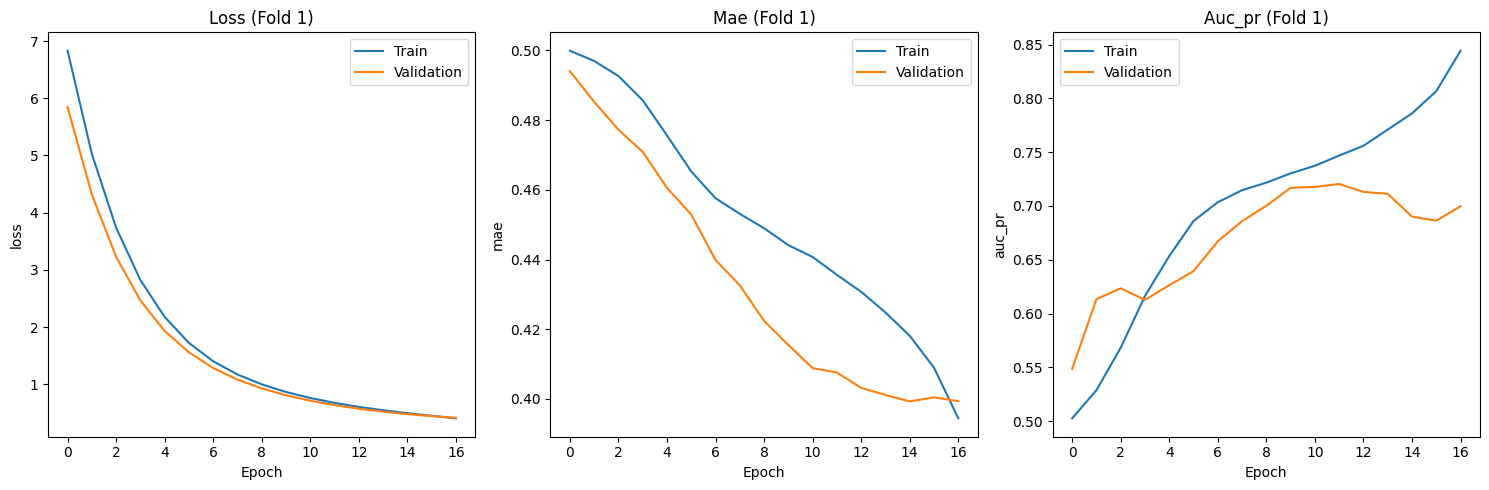

Training on Fold 2
Epoch 1/40
   1458/Unknown 19s 9ms/step - auc_pr: 0.4926 - loss: 7.2806 - mae: 0.5006

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1460/1460 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - auc_pr: 0.4926 - loss: 7.2794 - mae: 0.5006 - val_auc_pr: 0.4871 - val_loss: 5.5611 - val_mae: 0.5008
Epoch 2/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.5087 - loss: 5.0928 - mae: 0.4997 - val_auc_pr: 0.5231 - val_loss: 3.8819 - val_mae: 0.4981
Epoch 3/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.5258 - loss: 3.5543 - mae: 0.4987 - val_auc_pr: 0.5866 - val_loss: 2.7097 - val_mae: 0.4944
Epoch 4/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.5521 - loss: 2.4866 - mae: 0.4971 - val_auc_pr: 0.6723 - val_loss: 1.9092 - val_mae: 0.4874
Epoch 5/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.6033 - loss: 1.7650 - mae: 0.4940 - val_auc_pr: 0.7058 - val_loss: 1.3731 - val_mae: 0.4742
Epoch 6/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.6727 - loss: 1.2846 - mae: 0.4853 - val_auc_pr: 0.7069 - val_loss: 1.0224 - val_mae: 0.4601
Epoch 7/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/

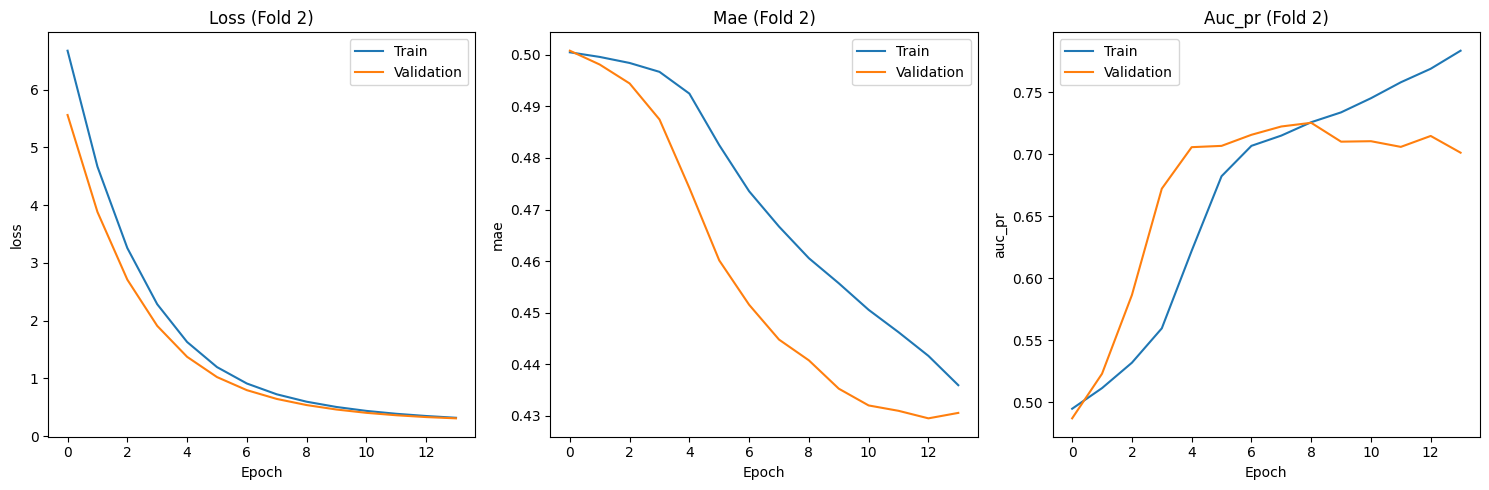

Training on Fold 3
Epoch 1/40
   1460/Unknown 19s 9ms/step - auc_pr: 0.4987 - loss: 7.2320 - mae: 0.5002

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1460/1460 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - auc_pr: 0.4987 - loss: 7.2316 - mae: 0.5002 - val_auc_pr: 0.4992 - val_loss: 5.4215 - val_mae: 0.5006
Epoch 2/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.5017 - loss: 4.9398 - mae: 0.5001 - val_auc_pr: 0.5188 - val_loss: 3.6758 - val_mae: 0.4998
Epoch 3/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.5202 - loss: 3.3397 - mae: 0.4995 - val_auc_pr: 0.5115 - val_loss: 2.4651 - val_mae: 0.4997
Epoch 4/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.5414 - loss: 2.2366 - mae: 0.4990 - val_auc_pr: 0.5602 - val_loss: 1.6521 - val_mae: 0.4978
Epoch 5/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - auc_pr: 0.5802 - loss: 1.5053 - mae: 0.4978 - val_auc_pr: 0.6625 - val_loss: 1.1310 - val_mae: 0.4926
Epoch 6/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.6459 - loss: 1.0416 - mae: 0.4947 - val_auc_pr: 0.7009 - val_loss: 0.8022 - val_mae: 0.4822
Epoch 7/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/

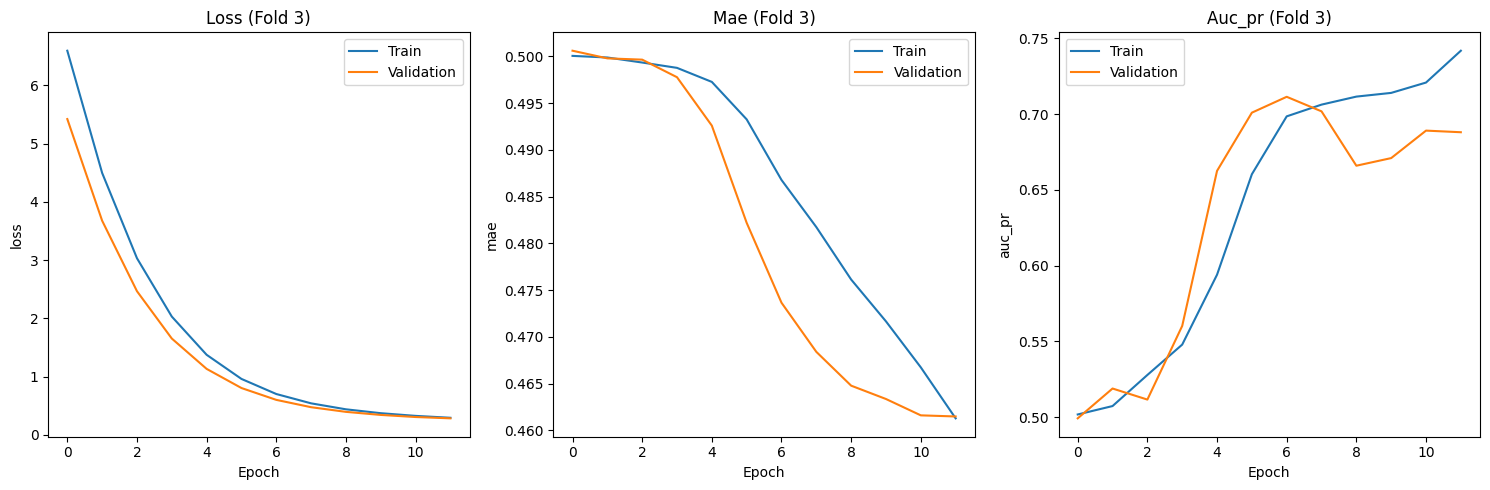

Training on Fold 4
Epoch 1/40
   1456/Unknown 21s 10ms/step - auc_pr: 0.5091 - loss: 7.4005 - mae: 0.4989

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1460/1460 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - auc_pr: 0.5091 - loss: 7.3987 - mae: 0.4989 - val_auc_pr: 0.5636 - val_loss: 5.8847 - val_mae: 0.4899
Epoch 2/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - auc_pr: 0.5427 - loss: 5.4474 - mae: 0.4950 - val_auc_pr: 0.6054 - val_loss: 4.3542 - val_mae: 0.4817
Epoch 3/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - auc_pr: 0.5738 - loss: 4.0382 - mae: 0.4905 - val_auc_pr: 0.6539 - val_loss: 3.2456 - val_mae: 0.4688
Epoch 4/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.6293 - loss: 3.0234 - mae: 0.4822 - val_auc_pr: 0.7095 - val_loss: 2.4482 - val_mae: 0.4495
Epoch 5/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.6840 - loss: 2.3004 - mae: 0.4692 - val_auc_pr: 0.7735 - val_loss: 1.8788 - val_mae: 0.4208
Epoch 6/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - auc_pr: 0.7669 - loss: 1.7838 - mae: 0.4439 - val_auc_pr: 0.8444 - val_loss: 1.4755 - val_mae: 0.3839
Epoch 7/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/

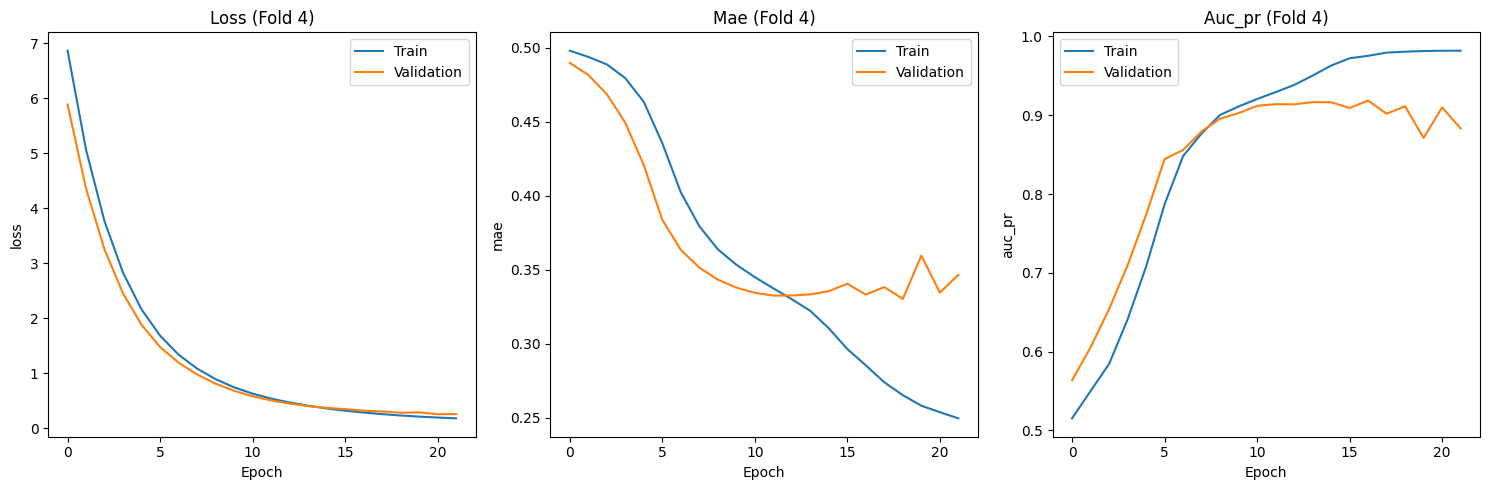

Training on Fold 5
Epoch 1/40
   1460/Unknown 19s 9ms/step - auc_pr: 0.4958 - loss: 7.3195 - mae: 0.5005

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1460/1460 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - auc_pr: 0.4958 - loss: 7.3191 - mae: 0.5005 - val_auc_pr: 0.4799 - val_loss: 5.6029 - val_mae: 0.5021
Epoch 2/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - auc_pr: 0.5112 - loss: 5.1341 - mae: 0.4994 - val_auc_pr: 0.5138 - val_loss: 3.9226 - val_mae: 0.4983
Epoch 3/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - auc_pr: 0.5400 - loss: 3.5939 - mae: 0.4980 - val_auc_pr: 0.5588 - val_loss: 2.7472 - val_mae: 0.4945
Epoch 4/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - auc_pr: 0.5767 - loss: 2.5223 - mae: 0.4953 - val_auc_pr: 0.6547 - val_loss: 1.9404 - val_mae: 0.4856
Epoch 5/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - auc_pr: 0.6352 - loss: 1.7934 - mae: 0.4905 - val_auc_pr: 0.6830 - val_loss: 1.3990 - val_mae: 0.4739
Epoch 6/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - auc_pr: 0.6789 - loss: 1.3061 - mae: 0.4830 - val_auc_pr: 0.7067 - val_loss: 1.0433 - val_mae: 0.4631
Epoch 7/40
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/

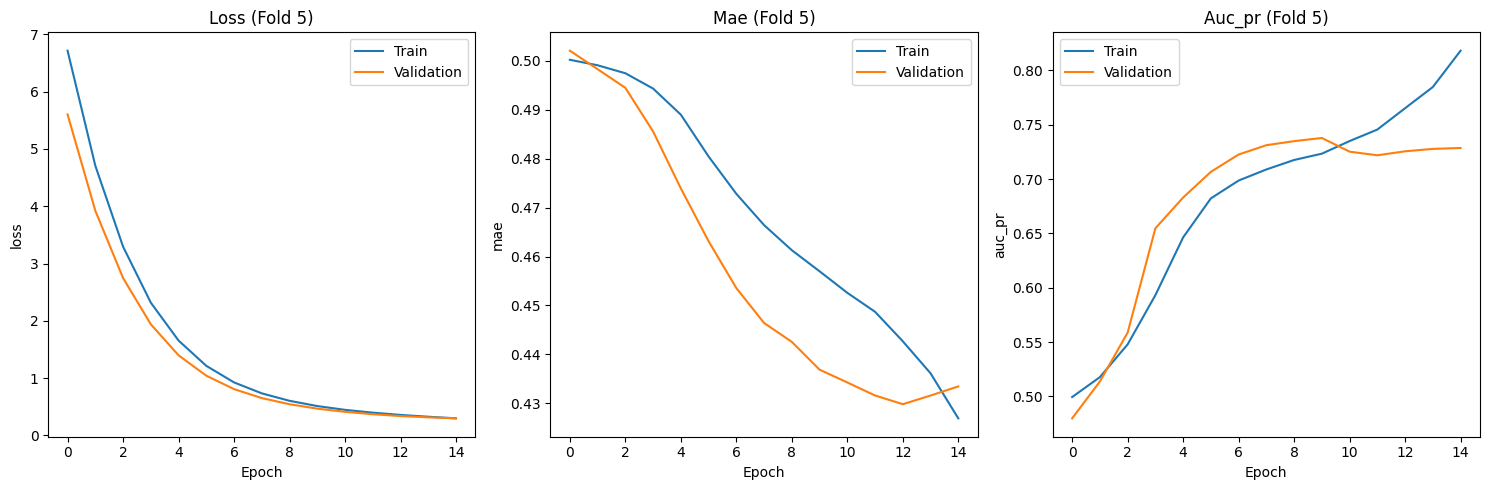

Average Validation Loss: 0.3116
Average Validation MAE: 0.4143
Average Validation AUC-PR: 0.7402
Average Validation ROC AUC: 0.7642


In [123]:
# K-fold Cross-Validation
fold_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
    print(f"Training on Fold {fold_idx + 1}")

    # Chia dữ liệu cho từng fold
    train_pairs, test_pairs = X_train_resampled[train_idx], X_train_resampled[test_idx]
    train_labels, test_labels = y_train_resampled[train_idx], y_train_resampled[test_idx]

    # Tạo mô hình cho mỗi fold
    siamese_model = create_siamese_network(input_shape)

    # Sử dụng BalancedBatchGenerator
    train_generator = BalancedBatchGenerator(train_pairs, train_labels, batch_size=64, positive_ratio=0.5)
    train_dataset = create_tf_dataset(train_generator).repeat(1)

    # Huấn luyện mô hình
    callbacks = [
        EarlyStopping(monitor='val_auc_pr', patience=5, restore_best_weights=True),
        TerminateOnNaN(),
        # ReduceLROnPlateau(monitor='val_auc_pr', factor=0.2, patience=5, min_lr=1e-6)
    ]
    history = siamese_model.fit(
        train_dataset,
        epochs=40,
        validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_labels),
        callbacks=callbacks,
        verbose=1
    )

    # Dự đoán và tính toán ROC AUC
    y_pred = siamese_model.predict([test_pairs[:, 0], test_pairs[:, 1]])
    roc_auc = roc_auc_score(test_labels, y_pred)
    print(f"ROC AUC for Fold {fold_idx + 1}: {roc_auc:.4f}")

    # Lưu kết quả
    fold_results.append({
        'loss': history.history['val_loss'][-1],
        'mae': history.history['val_mae'][-1],
        'auc_pr': history.history['val_auc_pr'][-1],
        'roc_auc': roc_auc
    })

    # Vẽ lịch sử huấn luyện
    plot_history(history, fold_idx)

# Hiển thị kết quả trung bình
average_loss = np.mean([result['loss'] for result in fold_results])
average_mae = np.mean([result['mae'] for result in fold_results])
average_auc_pr = np.mean([result['auc_pr'] for result in fold_results])
average_roc_auc = np.mean([result['roc_auc'] for result in fold_results])

print(f"Average Validation Loss: {average_loss:.4f}")
print(f"Average Validation MAE: {average_mae:.4f}")
print(f"Average Validation AUC-PR: {average_auc_pr:.4f}")
print(f"Average Validation ROC AUC: {average_roc_auc:.4f}")

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Sau khi huấn luyện mô hình
y_pred = siamese_model.predict([X_test[:, 0], X_test[:, 1]])
y_pred_classes = (y_pred > 0.5).astype(int)

# Tính toán các chỉ số
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

# Đánh giá mô hình trên tập kiểm tra
test_loss, test_mae, test_auc_pr = siamese_model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")
print(f"Test AUC (PR): {test_auc_pr}")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - auc_pr: 0.3170 - loss: 0.4550 - mean_absolute_error: 0.4256
Test Loss: 0.45428821444511414
Test MAE: 0.4247729480266571
Test AUC (PR): 0.3380962312221527
Accuracy: 0.7661
Precision: 0.3291
Recall: 0.5732
F1 Score: 0.4182


In [127]:
# Định nghĩa đường dẫn lưu mô hình tốt nhất
best_model_path = "/kaggle/working/best_siamese_model.h5"

# Tìm fold tốt nhất dựa trên AUC-PR
best_fold_idx = np.argmax([result['auc_pr'] for result in fold_results])
print(f"Best fold: {best_fold_idx + 1}")

# Lưu mô hình tốt nhất vào đường dẫn
siamese_model.save(best_model_path)
print(f"Best model saved at: {best_model_path}")

Best fold: 4
Best model saved at: /kaggle/working/best_siamese_model.h5


In [128]:
distances = siamese_model.predict([X_test[:, 0], X_test[:, 1]])
same_pairs = distances[y_test == 1]
different_pairs = distances[y_test == 0]

print(f"Khoảng cách trung bình của cặp giống nhau: {np.mean(same_pairs)}")
print(f"Khoảng cách trung bình của cặp khác nhau: {np.mean(different_pairs)}")

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Khoảng cách trung bình của cặp giống nhau: 0.5402833819389343
Khoảng cách trung bình của cặp khác nhau: 0.4187694489955902


535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[[11663  2929]
 [ 1070  1437]]


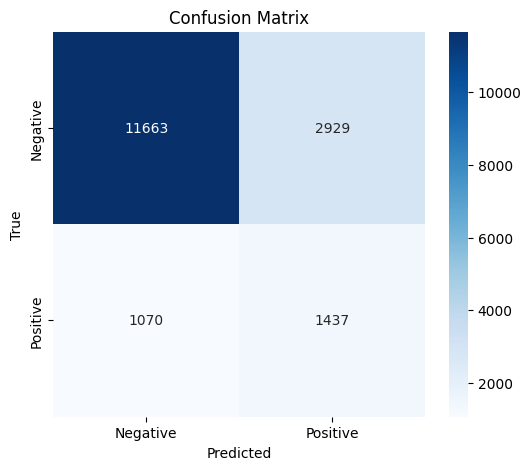

In [129]:
import seaborn as sns
# Dự đoán nhãn cho tập kiểm tra
y_pred = siamese_model.predict([X_test[:, 0], X_test[:, 1]])

# Chuyển kết quả dự đoán sang dạng nhãn (0 hoặc 1) dựa trên ngưỡng 0.5
y_pred_class = (y_pred > 0.5).astype(int)

# Tạo confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
print(cm)

# Vẽ confusion matrix dưới dạng heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [130]:
# In báo cáo đánh giá
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.92      0.80      0.85     14592
           1       0.33      0.57      0.42      2507

    accuracy                           0.77     17099
   macro avg       0.62      0.69      0.64     17099
weighted avg       0.83      0.77      0.79     17099



# **Xử lý yêu cầu người dùng**

In [131]:
import re
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras import backend as K

In [132]:
def fix_request(user_request):
    user_request = user_request.replace('và', ',')
    user_request = user_request.replace('để', '')
    user_request = user_request.replace('  ', ' ')
    user_request = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), user_request, flags=re.IGNORECASE)
    user_request = user_request.lower().strip()
    return user_request

def extract_features(user_request):
    user_request = fix_request(user_request)

    # Tách số tầng
    floors = re.search(r'(\d+)\s*tầng', user_request)
    num_floors = int(floors.group(1)) if floors else 1  # Mặc định 1 tầng nếu không tìm thấy

    # Tách diện tích tổng
    area = re.search(r'diện tích\s*(\d+\.?\d*)\s', user_request)
    total_area = float(area.group(1)) if area else None

    # Tìm các loại phòng và số lượng
    rooms = {}
    room_matches = re.findall(r'(\d+)?\s*(phòng ngủ|phòng khách|bếp|wc|nhà vệ sinh)', user_request)
    for count, room_type in room_matches:
        count = int(count) if count else 1  # Nếu không có số lượng, mặc định là 1
        normalized_type = {
            "phòng khách": "living_room",
            "bếp": "kitchen",
            "nhà bếp": "kitchen",
            "phòng ngủ": "bedroom",
            "wc": "wc",
            "nhà vệ sinh": "wc"
        }.get(room_type, room_type)

        if normalized_type in ["bedroom", "wc"]:
            for i in range(1, count + 1):
                rooms[f"{normalized_type}_{i}"] = 1
        else:
            rooms[normalized_type] = rooms.get(normalized_type, 0) + count

    # Thêm mặc định nếu không tìm thấy "wc"
    if not any(k.startswith("wc") for k in rooms.keys()):
        rooms["wc_1"] = 1

    # Tìm các đặc điểm khác
    features = set()

    feature_keywords = {
        "sảnh chính": "main_hall",
        "sảnh phụ": "side_hall",
        "khu vực giặt": "laundry_area",
        "phòng thờ": "worship_room",
        "sân trước": "frontyard", 
        "sân sau": "backyard",
        "sân chơi": "playground",
        "sân phơi": "drying_yard", 
        "sân thượng": "rooftop",
        "bar": "bar",
        "gara": "garage",
        "hành lang nội bộ": "internal_corridor", 
        "ban công":  "balcon",
        "sảnh": "lobby",
        "sân": "yard",
        "thư viện": "library", 
        "logia": "logia",
        "giếng trời": "skylight",
        "massage": "massage_room",
        "karaoke": "karaoke_room",
        "đa năng": "multi-purpose_room",
        "trồng cây": "planting_yard",
        "yoga": "yoga_room",
        "thay đồ": "dressing_room",
        "thể thao": "sports_area",
        "thư giãn": "relaxation_room",
        "kho": "warehouse",
        "chơi": "playground",
        "tiểu cảnh": "miniatures",
        "cầu thang": "stair_hall",
        "khu thờ": "worship_area",
        "phòng sinh hoạt chung": "common_room",
        "không gian kinh doanh": "business_space",
        "hành lang": "hallway",
        "phòng kỹ thuật": "technical_room",
        "phòng giặt": "laundry_room",   
        "đậu xe": "parking_yard",
        "khu sinh hoạt chung": "common_area",
        "phòng thể thao": "sports_room",
        "làm việc": "working_room",
        
    }

    for keyword, feature in feature_keywords.items():
        if keyword in user_request:
            features.add(feature)

    return {
        "floors": num_floors,
        "total_area": total_area,
        "rooms": rooms,
        "features": list(features)
    }


In [133]:
# Xác định danh sách các loại phòng và tính năng để tạo các vector có chiều cố định
room_types = ["living_room", "bedroom_1", "bedroom_2", "bedroom_3", "bedroom_4", "bedroom_5", "bedroom_6", "kitchen", "wc_1", "wc_2", "wc_3", "wc_4", "wc_5", "wc_6", "wc_7", "wc_8"]
features_list = ["yard", "main_hall", "side_hall", "laundry_area", "worship_room", "frontyard", "backyard",
                 "bar", "garage", "internal_corridor", "balcon", "lobby", "drying_yard", "library", "common_room",
                 "playground", "business_space", "hallway", "stair_hall", "side_hall", "warehouse", "technical_room",
                "miniatures", "dressing_room", "sports_area", "laundry_room", "relaxation_room", "parking_yard",
                 "skylight", "logia", "planting_yard", "yoga_room", "common_area", "sports_area", "karaoke_room",
                 "massage_room", "multi-purpose_room", "working_room", "sports_room", "rooftop"]

In [134]:
def create_user_embedding(user_request):
    # Trích xuất các đặc trưng từ yêu cầu
    features = extract_features(user_request)

    # Tách thông tin cụ thể từ các đặc trưng
    num_floors = features['floors']  # Số tầng
    total_area = features['total_area'] or 0  # Tổng diện tích, mặc định là 0 nếu không có
    rooms = features['rooms']  # Các phòng và diện tích
    user_features = features['features']  # Các tính năng

    # Mã hóa thông tin về phòng (giả sử room_types đã được định nghĩa)
    room_embedding = [rooms.get(room, 0) for room in room_types]  # Sử dụng danh sách `room_types` làm chuẩn

    # Mã hóa các tính năng bổ sung
    feature_embedding = [1 if feature in user_features else 0 for feature in features_list]  # Sử dụng `features_list`

    # Kết hợp tất cả các thông tin thành một vector embedding
    user_embedding = np.array(
        [num_floors, total_area] + room_embedding + feature_embedding,
        dtype=np.float32
    )

    # Kiểm tra và điều chỉnh kích thước embedding
    target_size = 61  # Kích thước cố định (đảm bảo tương thích với các embedding khác)
    if user_embedding.shape[0] < target_size:
        # Pad nếu thiếu
        user_embedding = np.pad(user_embedding, (0, target_size - user_embedding.shape[0]), mode='constant', constant_values=0)
    elif user_embedding.shape[0] > target_size:
        # Cắt bớt nếu quá
        user_embedding = user_embedding[:target_size]

    return user_embedding

In [135]:
# Test hàm
user_request = "Nhà 2 tầng, diện tích 200m², 3 phòng ngủ, 1 phòng khách và bếp, có gara và ban cônggggg. khu vực thờ , phòng giặt đồ, sảnh chờ, khu vực phơi, bar, sân chơi"
extracted_features = extract_features(user_request)
print(extracted_features)

user_embedding = create_user_embedding(user_request)
print("Embedding cho yêu cầu người dùng:", user_embedding)
print("Kích thước embedding:", user_embedding.shape)

{'floors': 2, 'total_area': None, 'rooms': {'bedroom_1': 1, 'bedroom_2': 1, 'bedroom_3': 1, 'living_room': 1, 'kitchen': 1, 'wc_1': 1}, 'features': ['garage', 'playground', 'bar', 'laundry_room', 'balcon', 'yard', 'lobby']}
Embedding cho yêu cầu người dùng: [2. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Kích thước embedding: (61,)


In [136]:
# Hàm cosine similarity
def cosine_similarity(tensors):
    # Kiểm tra xem tensors có phải là một cấu trúc lồng nhau hay không
    if isinstance(tensors, (list, tuple)):
        tensors = tuple(tensors)
    x, y = tensors
    x_norm = K.sqrt(K.sum(K.square(x), axis=1, keepdims=True)) + K.epsilon()
    y_norm = K.sqrt(K.sum(K.square(y), axis=1, keepdims=True)) + K.epsilon()
    cos_sim = K.sum(x * y, axis=1, keepdims=True) / (x_norm * y_norm)
    return cos_sim
    
def contrastive_loss(y_true, y_pred):
    margin = 1.0  # Độ lệch margin
    y_true = tf.cast(y_true, tf.float32)
    
    # Giới hạn giá trị của y_pred trong khoảng [0, 1]
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
    
    # Công thức tính contrastive loss
    loss = (1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0))
    
    return K.mean(loss)

In [113]:
from tensorflow.keras.layers import Lambda
for layer in siamese_model.layers:
    if isinstance(layer, Lambda):
        print("Lambda layer config:", layer.get_config())


Lambda layer config: {'name': 'lambda_11', 'trainable': True, 'dtype': 'float32', 'function': {'module': 'builtins', 'class_name': 'function', 'config': 'cosine_similarity', 'registered_name': 'function'}, 'output_shape': (1,), 'arguments': {}}


In [137]:
from functools import partial
# Đường dẫn tới mô hình đã lưu
model_path = os.path.abspath('/kaggle/working/best_siamese_model.h5')
 # Sử dụng partial để truyền đúng dạng đầu vào
cosine_similarity_fn = partial(cosine_similarity)

try:
    siamese_model = load_model(
        model_path,
        custom_objects={'cosine_similarity': cosine_similarity_fn, 'contrastive_loss': contrastive_loss}
    )
    print("Model loaded successfully!")
    siamese_model.summary()
except Exception as e:
    print("Error loading model:", e)


Model loaded successfully!


Model: "functional_805"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_78      │ (None, 61)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_79      │ (None, 61)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_26       │ (None, 61)        │    212,029 │ input_layer_78[0… │
│ (Sequential)        │                   │            │ input_layer_79[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_26 (Lambda)  │ (None, 1)         │          0 │ sequential_26[0]… │
│                     │                   │            │ sequential_26[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_161 (Dense)   │ (None, 1)         │          2 │ lambda_26[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 212,033 (828.26 KB)

 Trainable params: 210,111 (820.75 KB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 2 (12.00 B)

In [138]:
print("User embedding:", user_embedding)
print("House embedding:", embeddings[1])

User embedding: [2. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
House embedding: [  2.    0.    1.5 100.    0.   11.   11.    0.    0.    0.    0.   25.
   5.4   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   1.    0.    0.    0.    0.    1.    1.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 926. ]


In [139]:
# Đọc dữ liệu từ file JSON
with open('/kaggle/input/technicaldrawing/labels.json', 'r') as f:
    house_details = json.load(f)

In [140]:
house_details[1]

{'house_id': 'house_2',
 'architectural_style': 'house',
 'floor': 1,
 'image_path': '/images/house_2_floor_1.jpg',
 'total_area': 100,
 'rooms': [{'type': 'living_room', 'area': 20},
  {'type': 'bedroom_1', 'area': 13.7},
  {'type': 'kitchen', 'area': 27.5},
  {'type': 'wc_1', 'area': 3}],
 'feature': ['backyard', 'frontyard', 'main_hall', 'internal_corridor']}

In [152]:
def predict_house(user_request, siamese_model, house_embeddings, house_details):
    # Tạo embedding cho yêu cầu người dùng
    user_embedding = create_user_embedding(user_request)

    similarities = []
    for house_detail, house_embedding in zip(house_details, house_embeddings):
        # Lấy embedding từ house_embedding
        house_embedding_array = np.array(house_embedding)

        # Dự đoán độ tương đồng bằng mô hình Siamese
        similarity = siamese_model.predict(
            [np.expand_dims(user_embedding, axis=0), np.expand_dims(house_embedding_array, axis=0)],
            verbose=0
        )[0][0]  # Giá trị độ tương đồng

        # Kết hợp thông tin chi tiết
        similarities.append({
            'similarity': similarity,
            **house_detail  # Kết hợp thông tin chi tiết về ngôi nhà
        })

    # Sắp xếp các ngôi nhà theo độ tương đồng giảm dần
    ranked_houses = sorted(similarities, key=lambda x: x['similarity'], reverse=True)

    # Trả về ngôi nhà tương đồng cao nhất
    return ranked_houses[:1]

Ngôi nhà có độ tương đồng cao nhất:
Tương đồng: 0.3686
Phong cách kiến trúc: house
Số tầng: 1
Diện tích: 200 m²
Các phòng: living_room: 31 m², bedroom_1: 13.4 m², bedroom_2: 14.1 m², bedroom_3: 16.3 m², kitchen: 20.5 m², wc_1: 3.2 m², wc_2: 3.4 m²
Các tiện ích: main_hall, side_hall, laundry_area, worship_room


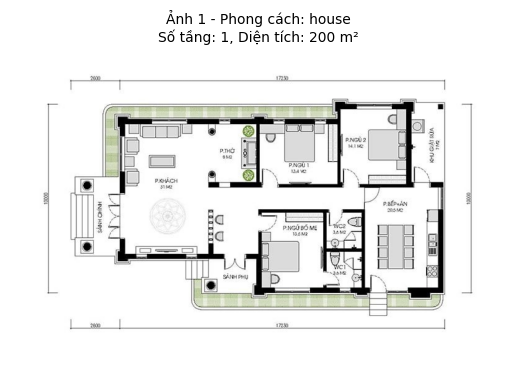

In [153]:
ranked_houses = predict_house(user_request, siamese_model, embeddings, house_details)

# Kiểm tra kết quả
if ranked_houses:  # Nếu có ít nhất một ngôi nhà được đề xuất
    house = ranked_houses[0]  # Lấy ngôi nhà có độ tương đồng cao nhất
    house_id = house['house_id']  # Lấy ID của ngôi nhà

    print("Ngôi nhà có độ tương đồng cao nhất:")
    print(f"Tương đồng: {house['similarity']:.4f}")
    print(f"Phong cách kiến trúc: {house['architectural_style']}")
    print(f"Số tầng: {house['floor']}")
    print(f"Diện tích: {house['total_area']} m²")
    
    # Thông tin về các phòng
    rooms = house.get('rooms', [])
    room_info = ', '.join([f"{room['type']}: {room['area']} m²" for room in rooms])
    print(f"Các phòng: {room_info}")
    
    # Thông tin về các tiện ích
    features = house.get('feature', [])
    feature_info = ', '.join(features)
    print(f"Các tiện ích: {feature_info}")
    
    # Tìm tất cả các ảnh liên quan đến house_id
    related_houses = [h for h in house_details if h['house_id'] == house_id]
    
    # Hiển thị tất cả các ảnh liên quan
    if related_houses:
        for idx, related_house in enumerate(related_houses):
            image_path = related_house.get('image_path', '')
            if image_path:  # Kiểm tra xem đường dẫn ảnh có tồn tại
                full_path = os.path.join("/kaggle/input/technicaldrawing/images", os.path.basename(image_path))
                
                # Hiển thị ảnh
                try:
                    with Image.open(full_path) as img:
                        plt.imshow(img)
                        plt.axis('off')
                        
                        # Hiển thị thông tin chi tiết dưới dạng tiêu đề
                        info = f"Ảnh {idx + 1} - Phong cách: {related_house['architectural_style']}\nSố tầng: {related_house['floor']}, Diện tích: {related_house['total_area']} m²"
                        plt.title(info, fontsize=10)
                        plt.show()
                except FileNotFoundError:
                    print(f"Không tìm thấy tệp ảnh: {full_path}")
    else:
        print(f"Không tìm thấy ảnh nào liên quan đến house_id: {house_id}")
else:
    print("Không có ngôi nhà nào được đề xuất.")